### 1. PDF 문서 이미지 추출

In [ ]:
%pip install unstructured==0.12.5 unistructured-inference
%pip install pdfminer.six==20231228
%pip install pdf2image pillow-heif opencv-python    


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/566.1 kB ? eta -:--:--
   ---------------------------------------- 566.1/566.1 kB 3.9 MB/s  0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 1.1.2
    Uninstalling huggingface_hub-1.1.2:
      Successfully uninstalled huggingface_hub-1.1.2
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 이미지 문서 추출
from unstructured.partition.pdf import partition_pdf
image_save_path = "./data_image/pdf2image" # 추출 할 이미지 저장 경로
fpath = "./data/2005.11401v4.pdf" # 사용 할 논문 파일 경로
'''
unstructured를 사용하여 pdf 이미지만 파일로 추출하기
'''
raw_pdf_elements = partition_pdf(
    filename=fpath,
    extract_images_in_pdf=True, # 이미지 추출
    extract_image_block_output_dir=image_save_path,
)


This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


In [2]:
# 이미지를 출력하는 함수 작성
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        img_path = img_path.lower() # 소문자화
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

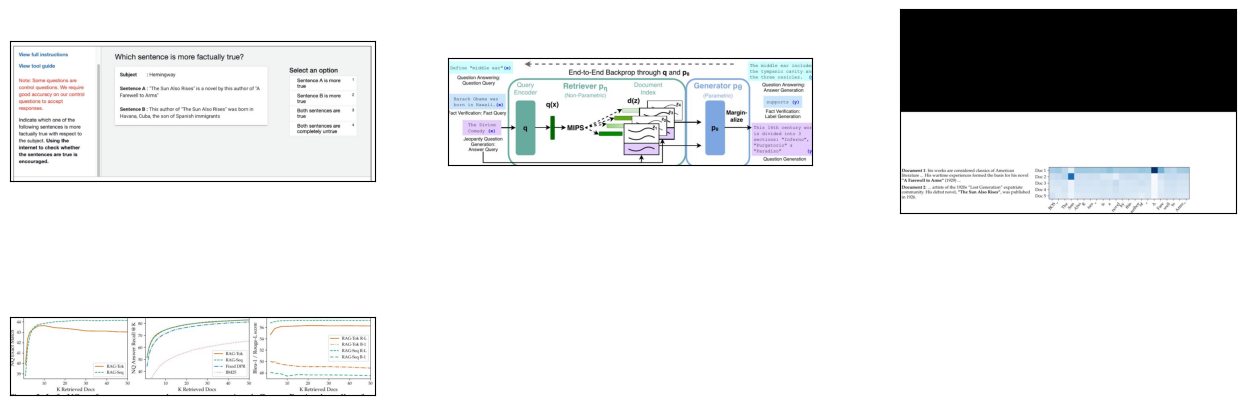

In [ ]:
# 추출 된 이미지 출력해보기
import os
image_save_path = "./data_image/pdf2image" # 추출 할 이미지 저장 경로
file_list = [os.path.join(image_save_path, f) for f in os.listdir(image_save_path)]
plot_images(file_list) # 추출 된 이미지 plot

### 2. PDF 문서 테이블, 텍스트 등 파서

In [ ]:
# 이미지를 문서로 읽어오기
from llama_index.core import SimpleDirectoryReader
image_save_path = "./data_image/pdf2image" # 이미지가 저장 된 경로
image_documents = SimpleDirectoryReader(input_dir=image_save_path).load_data()
print(f"이미지 문서 개수 : {len(image_documents)}")


이미지 문서 개수 : 4


In [5]:
# 저장 된 이미지 타입 확인
for doc in image_documents:
    print(type(doc))

<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>
<class 'llama_index.core.schema.ImageDocument'>


In [ ]:
# Step1. .evn 파일 로드 및 비동기 문제 해결
from dotenv import load_dotenv 
import nest_asyncio
load_dotenv() # 환경 변수 설정
nest_asyncio.apply() # 비동기 처리 문제 해결

In [ ]:
# Step2. 라마파스 사용하여 문서 로드하기
from llama_parse import LlamaParse
parser = LlamaParse(result_type="text") # markdown 혹은 text 사용 가능
file_extractor = {".pdf": parser}  # PDF 파일을 LlamaParse로 처리하도록 설정
fpath = "./data/2005.11401v4.pdf" # 사용 할 논문 파일 경로
text_documents = SimpleDirectoryReader(
    input_files=[fpath], # 논문 저장경로
    file_extractor=file_extractor
).load_data()

2025-09-29 19:25:57,519 - INFO - HTTP Request: POST https://api.cloud.llamaindex.ai/api/parsing/upload "HTTP/1.1 200 OK"


Started parsing the file under job_id 12986e81-d5f3-4037-8dce-e50998014d3a


2025-09-29 19:25:58,855 - INFO - HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/12986e81-d5f3-4037-8dce-e50998014d3a "HTTP/1.1 200 OK"
2025-09-29 19:26:01,190 - INFO - HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/12986e81-d5f3-4037-8dce-e50998014d3a "HTTP/1.1 200 OK"
2025-09-29 19:26:01,703 - INFO - HTTP Request: GET https://api.cloud.llamaindex.ai/api/parsing/job/12986e81-d5f3-4037-8dce-e50998014d3a/result/text "HTTP/1.1 200 OK"


In [8]:
print(f"논문 TEXT 문서 개수 : {len(text_documents)}")

논문 TEXT 문서 개수 : 19


### 3. 이미지 캡셔닝

ImageDocuments는 llama-index 0.14.2(25년9월 기준) 버전 기준으로 멀티모달 LLM 호출에 전달할 때, 사용불가
ImageNode로 사용하는 것으로 권장

In [ ]:
# Step1. ImageDocument를 ImageNode로 변환

from llama_index.core.schema import ImageDocument, ImageNode 
from typing import List

# 이미지 문서 -> 이미지 노드 변환함수 작성(이미지 경로 포함)
def docs_to_image_nodes(img_docs: List[ImageDocument]) -> List[ImageNode]:
    nodes = []
    for d in img_docs:
        # 우선순위: d.image_path -> d.metadata["file_path"] -> None
        path = getattr(d, "image_path", None) or d.metadata.get("file_path")
        node = ImageNode(
            image_path=path,                # ✅ 경로를 여기에
            image_url=getattr(d, "image_url", None),
            image=getattr(d, "image", None),  # base64일 수 있음
            metadata=dict(d.metadata),     # 기존 메타데이터 유지
            text=getattr(d, "text", None),
        )
        nodes.append(node)
    return nodes

In [ ]:
# Step2. 이미지 요약을 생성하고 캡션을 추가하는 함수 작성

from llama_index.multi_modal_llms.openai import OpenAIMultiModal

# 이미지 캡셔닝 함수 정의
def summarize_images_captioning(image_nodes: list[ImageNode]) -> List[ImageNode]:
    # 멀티모달 모델 인스턴스화
    openai_mm_llm = OpenAIMultiModal(
        model='gpt-4o',         # 실제 사용하는 모델명으로 변경
        max_new_tokens=3000,
        temperature=0.5
    )
    
    prompt_template = """
    당신은 주어진 이미지를 텍스트로 설명을 바꾸는 역할을 해야 합니다.
    이미지에 대한 상세 설명을 해주세요.
    해당 이미지에 텍스트나 숫자, 수식 등이 있는 경우 해당 용어를 반드시 모두 사용해서 어떤 그림인지 설명해주세요.
    그래프나 차트의 경우도 숫자, 수식 등의 데이터를 포함하여 상세 설명해주시길 바랍니다.
    """
    
    for img_node in image_nodes:
        # 이미지를 단건으로 넣어서 각각 요약(캡션) 생성
        response = openai_mm_llm.complete(
            prompt=prompt_template,
            image_documents=[img_node]
        )
        # ImageNode의 metadata에 요약 text를 저장하는('caption')을 추가
        img_node.metadata["caption"] = response.text
    
    # 메타데이터가 갱신된 ImageDocument 리스트 반환
    return image_nodes


In [11]:
# 이미지 문서를 노드로 변환시키고 LLM을 통한 설명 요약을 캡션에 추가 
doc_to_nodes = docs_to_image_nodes(img_docs=image_documents) # 이미지 노드 변환
image_nodes = summarize_images_captioning(image_nodes=doc_to_nodes) # 이미지 노드에 캡셔닝 추가

C:\Users\USER\AppData\Local\Temp\ipykernel_5332\439797361.py:6: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(
2025-09-29 19:40:09,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-29 19:40:20,151 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-29 19:40:33,989 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-09-29 19:40:49,106 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [12]:
# 이미지 노드 첫 요소 출력
print(f'Type : {type(image_nodes[0])}\n')
print('Metadata :')
print(image_nodes[0].metadata)

Type : <class 'llama_index.core.schema.ImageNode'>

Metadata :
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-17-4.jpg', 'file_name': 'figure-17-4.jpg', 'file_type': 'image/jpeg', 'file_size': 57138, 'creation_date': '2025-04-13', 'last_modified_date': '2025-09-23', 'caption': '이미지는 특정 주제에 대한 사실 여부를 판단하는 질문을 포함하고 있습니다. \n\n- 왼쪽 상단에는 "View full instructions"와 "View tool guide"라는 파란색 링크가 있습니다.\n- 그 아래에는 빨간색 텍스트로 "Note: Some questions are control questions. We require good accuracy on our control questions to accept responses."라는 문장이 있습니다.\n- 빨간색 텍스트 아래에는 "Indicate which one of the following sentences is more factually true with respect to the subject. Using the internet to check whether the sentences are true is encouraged."라는 문장이 있습니다.\n\n중앙에는 "Which sentence is more factually true?"라는 질문이 있으며, 그 아래에는 다음과 같은 정보가 포함되어 있습니다.\n\n- Subject: Hemingway\n- Sentence A: "The Sun Also Rises" is a novel by this author of "A Fare

In [ ]:
# Step3. ImageNode를 Document로 변환

'''
이미지 요약 텍스트를 추가한 Image Node를 Document 객체로 변환한다.
실제 이미지를 텍스트를 통해 검색될 수 있도록 객체를 변환하는 과정
이 때 image id를 추가해 원본 이미지를 참조할 수 있게 한다.
'''
from llama_index.core.schema import Document, NodeRelationship, RelatedNodeInfo
new_caption_docs = []
for img_node in image_nodes:
    caption = img_node.metadata["caption"]  # 앞 단계에서 넣어둔 캡션
    caption_doc = Document(
        text=caption,
        metadata={
            "source": img_node.metadata.get("source", ""),
            "is_image_caption": True, # 이미지 캡셔닝 대상임을 표시
            
            # 조회 편의용으로 저장
            "image_path": img_node.image_path,      # node의 image_path
            "image_node_id": img_node.id_,          # 조회 키
        },
    )
    # 관계로도 연결
    caption_doc.relationships[NodeRelationship.SOURCE] = RelatedNodeInfo(
        node_id=img_node.id_
    )
    new_caption_docs.append(caption_doc)

In [ ]:
new_caption_docs[0]  # 제대로 변환되었는지 첫 요소 확인하기(ImageNode -> Document로 제대로 변환되었는지 확인)

Document(id_='a2893a5e-a0be-4d7f-a578-14c34929cd9c', embedding=None, metadata={'source': '', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-17-4.jpg', 'image_node_id': 'aa22aa55-265c-45ea-83a4-7c8cd19c8dfe'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='aa22aa55-265c-45ea-83a4-7c8cd19c8dfe', node_type=None, metadata={}, hash=None)}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='이미지는 특정 주제에 대한 사실 여부를 판단하는 질문을 포함하고 있습니다. \n\n- 왼쪽 상단에는 "View full instructions"와 "View tool guide"라는 파란색 링크가 있습니다.\n- 그 아래에는 빨간색 텍스트로 "Note: Some questions are control questions. We require good accuracy on our control questions to accept responses."라는 문장이 있습니다.\n- 빨간색 텍스트 아래에는 "Indicate which one of the following sentences is more factually true with 

In [15]:
# 논문 text document + 이미지 text 캡셔닝 Document + 이미지 Document
documents = text_documents+new_caption_docs+image_documents 
print(f'문서의 개수 : {len(documents)}')

문서의 개수 : 27


### 4. 인덱스 생성 및 RAG 구현

In [ ]:
# Step1. 인덱스 생성 및 저장
# 신규 생성 (기존 경로가 이미 존재 할 경우 불러옴)
from qdrant_client import QdrantClient
client = QdrantClient(path="./index/ch05_3_4_pdf_to_index_db")

In [17]:
from llama_index.vector_stores.qdrant import QdrantVectorStore

# 텍스트에 대한 벡터 스토어 구성
text_store= QdrantVectorStore(client=client,
                              collection_name="text_collection")
# 이미지에 대한 벡터 스토어 구성
image_store = QdrantVectorStore(client=client, 
                              collection_name="image_collection")

# stroage context를 통해 멀티모달 벡터 스토어 및 인덱스를 통합관리
from llama_index.core import StorageContext
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store
)

In [ ]:
# 멀티 모달 인덱스 구성 및 저장
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
index = MultiModalVectorStoreIndex.from_documents(
    documents=documents, # 표/텍스트 문서+이미지 문서+이미지 캡셔닝 문서
    storage_context=storage_context,
)
index.storage_context.persist(persist_dir="./index/ch05_3_4_pdf_to_index_db")

c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-28 14:01:28,957 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\llama_index\vector_stores\qdrant\base.py:644: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [18]:
# 저장된 StorageContext 로드
from llama_index.core import load_index_from_storage

storage_context = StorageContext.from_defaults(
    persist_dir="./index/ch05_3_4_pdf_to_index_db",
    vector_store=text_store,
    image_store=image_store
)

# 저장된 인덱스 로드
index = load_index_from_storage(storage_context)

2025-09-29 19:41:38,468 - INFO - Loading all indices.


Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_4_pdf_to_index_db\docstore.json.
Loading llama_index.core.storage.kvstore.simple_kvstore from ./index/ch05_3_4_pdf_to_index_db\index_store.json.


c:\Users\USER\OneDrive\Desktop\Project\llamaindex_practice\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 5. 유사도 검색 및 결과 출력(이미지 포함)

In [ ]:
# Step2. 유사도 검색 및 결과 출력(이미지 포함)
from PIL import Image
import matplotlib.pyplot as plt

# 이미지를 출력하는 함수 작성
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        img_path = img_path.lower() # 소문자화
        if ".jpg" in img_path:
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

In [20]:
retriever_engine = index.as_retriever(
    similarity_top_k = 2, # 텍스트(Document) 노드 상위 2개 검색
    image_similarity_top_k = 2, # 이미지(ImageDocument) 노드 상위 2개 검색
)

In [21]:
# 쿼리 입력 및 검색(이미지, 텍스트 조회)
nodes = retriever_engine.retrieve('Please tell me about Query Encoder') 

# 텍스트 요약 캡셔닝을 한 문서가 제대로 검색 출력되는지 확인
captioning_image_paths=[] # Document 중 이미지 캡셔닝 문서 Node
image_node_paths=[] # ImageDocument로 검색 된 Node
for node in nodes:
    print(node)
    if 'is_image_caption' in node.metadata: # 노드의 메타데이터에 is_image_caption 키가 있는 경우  
        captioning_image_paths.append(node.metadata['image_path'])
    if type(node.node) == ImageNode: # ImageDocument로 인해 생성 된 노드인 경우
        image_node_paths.append(node.metadata['file_path'])

2025-09-29 19:42:12,194 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Node ID: 4b30793f-9336-485e-8bf4-23baabf25991
Text: 이 이미지는 정보 검색과 생성 과정을 설명하는 다이어그램입니다. 주요 구성 요소는 다음과 같습니다.  1.
**Query Encoder**: 입력된 쿼리 \( x \)를 인코딩하여 벡터 \( q(x) \)로 변환합니다. 예시로는
"Define 'middle ear'", "Barack Obama was born in Hawaii.", "The Divine
Comedy" 등이 있습니다.  2. **Retriever \( p_n \) (Non-Parametric)**: 인코딩된 쿼리
\( q(x) \)를 사용하여 문서 인덱스에서 관련 문서 \( d(z) \)를 검색합니다. 이는 MIPS(Maximum
Inner Prod...
Score:  0.798

Node ID: 6601f4ca-5d92-4625-978e-eb7008f3eb2a
Text: Define□"middle□ear"(x)                   End-to-End Backprop
through q and p                   The□middle□ear□includes
θ                                            the□tympanic□cavity□and
Question Answering:
the□three□ossi...
Score:  0.762

Node ID: 03110dc4-2a06-4a92-ac67-3994cba94db1
Text:
Score:  0.270

Node ID: 2032b185-6bd8-4f79-8daa-6b4797f656cc
Text:
Score:  0.231



** 이미지 캡셔닝 문서로 검색 된 이미지 출력 *


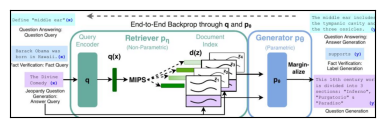

In [24]:
print('** 이미지 캡셔닝 문서로 검색 된 이미지 출력 *')
plot_images(image_paths=captioning_image_paths) # 이미지 plot

** ImageDocument로 검색 된 노드 이미지 출력 *


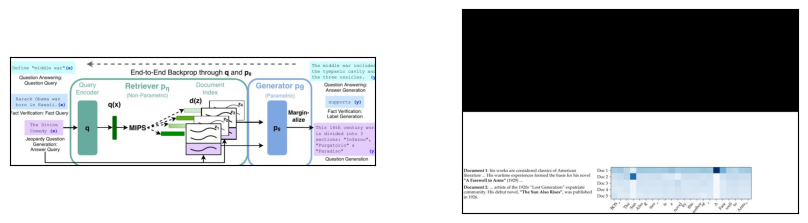

In [25]:
print('** ImageDocument로 검색 된 노드 이미지 출력 *')
plot_images(image_paths=image_node_paths) # 이미지 plot

In [ ]:
# 노드의 타입 및 메타데이터 확인
for n in nodes:
    node = getattr(n, "node", n)   # NodeWithScore → node 꺼내기
    print(f"Type : {type(node)}")
    print(f"Metadata keys : {node.metadata.keys()}\n")

Type : <class 'llama_index.core.schema.TextNode'>
Metadata keys : dict_keys(['source', 'is_image_caption', 'image_path', 'image_node_id'])

Type : <class 'llama_index.core.schema.TextNode'>
Metadata keys : dict_keys(['file_path', 'file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date'])

Type : <class 'llama_index.core.schema.ImageNode'>
Metadata keys : dict_keys(['file_path', 'file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date'])

Type : <class 'llama_index.core.schema.ImageNode'>
Metadata keys : dict_keys(['file_path', 'file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date'])



### 6. 쿼리 엔진 검색 시스템 구현
[참고] 이미지 캡셔닝을 통해 모든 imageDocument -> Document로 변경 후, Document로만 RAG 시스템을 구성시 OpenAIMultiModal 클래스를 사용하지 않고 
기존 일반 텍스트 처리 모델 OpenAI 를 사용해도 무관합니다. Document 객체에서 이미지에 대한 metadata 를 추가했기 때문입니다.
단, 이미지 문서인 ImageDocument를 같이 입력하는 멀티 모달 RAG를 같이 구현하는 경우에는 OpenAIMultiModal을 사용해야 합니다. 이번 실습에서는 ImageDocument와 Document가 섞여있는 구조로 OpenAIMultiModel을 사용합니다

In [ ]:
# Step3. 쿼리 엔진 구현
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(model="gpt-4o", 
                                 max_new_tokens=3000,)

query_engine = index.as_query_engine(
    llm=openai_mm_llm,
    similarity_top_k = 1, # Document 1개 반환
    image_similarity_top_k = 1 # ImageDocument 1개 반환
)

C:\Users\USER\AppData\Local\Temp\ipykernel_5332\599101455.py:2: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(model="gpt-4o",


In [65]:
from llama_index.core import PromptTemplate
# 프롬프트 템플릿 정의
template = (
    "제공 된 정보를 참고하여 한국어로 답변을 해주세요.\n"
    "{query_str}\n"
)
prompt_template = PromptTemplate(template)

In [ ]:
query_str = "Please tell me about Query Encoder"
final_prompt = prompt_template.format(query_str=query_str)
response = query_engine.query(final_prompt)

# prompt와 response 출력
print(f"Prompt:{final_prompt}")
print(f"Response:\n{response}")

2025-09-29 22:44:14,926 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-09-29 22:44:18,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Prompt:제공 된 정보를 참고하여 한국어로 답변을 해주세요.
Please tell me about Query Encoder

Response:
Query Encoder는 입력된 쿼리 \( x \)를 인코딩하여 벡터 \( q(x) \)로 변환하는 역할을 합니다. 예시로는 "Define 'middle ear'", "Barack Obama was born in Hawaii.", "The Divine Comedy" 등이 있습니다. 이 과정은 정보 검색 시스템에서 쿼리를 이해하고 처리하기 위한 첫 번째 단계입니다.


In [ ]:
from llama_index.core.schema import ImageNode, TextNode
image_paths=[] # 이미지 경로 및 노드 타입 저장
for n in response.source_nodes:
    node = getattr(n, "node", n)   # NodeWithScore → node 꺼내기
    print(f"Node : \n{node}\nType : {type(node)}\nMeta data : \n{node.metadata}\n")
    if isinstance(node, TextNode):
        if 'is_image_caption' in node.metadata.keys():
            image_paths.append(('Text Node', node.metadata['image_path']))
    if isinstance(node, ImageNode):
        image_paths.append(('Image Node', node.metadata['file_path']))

Node : 
Node ID: 4b30793f-9336-485e-8bf4-23baabf25991
Text: 이 이미지는 정보 검색과 생성 과정을 설명하는 다이어그램입니다. 주요 구성 요소는 다음과 같습니다.  1.
**Query Encoder**: 입력된 쿼리 \( x \)를 인코딩하여 벡터 \( q(x) \)로 변환합니다. 예시로는
"Define 'middle ear'", "Barack Obama was born in Hawaii.", "The Divine
Comedy" 등이 있습니다.  2. **Retriever \( p_n \) (Non-Parametric)**: 인코딩된 쿼리
\( q(x) \)를 사용하여 문서 인덱스에서 관련 문서 \( d(z) \)를 검색합니다. 이는 MIPS(Maximum
Inner Prod...
Type : <class 'llama_index.core.schema.TextNode'>
Meta data : 
{'source': '', 'is_image_caption': True, 'image_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg', 'image_node_id': 'fd85fbe8-c1c8-467a-920b-afe379de9a0b'}

Node : 
Node ID: 03110dc4-2a06-4a92-ac67-3994cba94db1
Text:
Type : <class 'llama_index.core.schema.ImageNode'>
Meta data : 
{'file_path': 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg', 'file_name': 'figure-2-1.jpg', 'file_type': 'imag

In [72]:
# 응답에 참고한 이미지 패스
for path in image_paths:
    print(path)

('Text Node', 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg')
('Image Node', 'c:\\Users\\USER\\OneDrive\\Desktop\\Project\\llamaindex_practice\\ch05\\data_image\\pdf2image\\figure-2-1.jpg')
